In [3]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm


class PairTradingBacktester:

    # METHOD 1 - Initialises key parameters and state variables
    def __init__(self, tickers, start_date, end_date, window=20,
                 entry_threshold=None, exit_threshold=None, cost_per_trade=0.001,
                 max_leverage=2, kelly_fraction=0.5, print_results=True):
        self.tickers = tickers                     # Pair of assets for trading
        self.start_date = start_date               # Start date for historical data
        self.end_date = end_date                   # End date for data (None uses most recent)
        self.window = window                       # Rolling window size for z-score calculation
        self.entry_threshold = entry_threshold     # Threshold to open a trade
        self.exit_threshold = exit_threshold       # Threshold to close a trade
        self.cost_per_trade = cost_per_trade       # Transaction cost per trade
        self.max_leverage = max_leverage           # Cap on leverage
        self.kelly_fraction = kelly_fraction       # Fraction of Kelly criterion to apply
        self.print_results = print_results         # Whether to print outputs
        self.data = None                           # Full data
        self.train = None                          # Training set
        self.test = None                           # Test set

    # METHOD 2 - Downloads adjusted close prices using yfinance
    def load_data(self):
        prices = yf.download(self.tickers, start=self.start_date, end=self.end_date, auto_adjust=True, progress=False)["Close"]
        self.data = prices.dropna()  # Drops any rows with missing data

    # METHOD 3 - Splits the data into training and testing sets
    def train_test_split(self, split_date):
        self.train = self.data[:split_date].copy()    # Data before the split date
        self.test = self.data[split_date:].copy()     # Data after the split date

    # METHOD 4 - Conducts a cointegration test between the two assets
    def check_cointegration(self):
        score, pvalue, _ = coint(self.train[self.tickers[0]], self.train[self.tickers[1]])

        if self.print_results == True:
            print(f"Cointegration test p-value: {pvalue:.4f}")
            
            RED = "\033[91m"
            GREEN = "\033[92m"
            RESET = "\033[0m"

            if pvalue < 0.05:
                print(f"{GREEN}Pair is cointegrated. Proceeding.{RESET}")
            else:
                print(f"{RED}WARNING: Pair is not cointegrated. Results may be unreliable.{RESET}")

        self.pvalue = pvalue  # Store p-value for potential external use

    # METHOD 5 - Searches for the best entry and exit thresholds to maximise Sharpe ratio
    def optimize_thresholds(self):
        best_sharpe = -np.inf
        best_params = None

        # Iterate through combinations of entry/exit thresholds
        for entry in np.arange(1.0, 2.5, 0.1):
            for exit in np.arange(0.2, 1.0, 0.1):
                df = self.train.copy()
                self.entry_threshold = entry
                self.exit_threshold = exit

                hedge_ratio = self.compute_hedge_ratio(df)
                df = self.compute_indicators(df, hedge_ratio)
                df = self.generate_signals(df, hedge_ratio)
                df = self.compute_returns(df)

                # Calculate Sharpe ratio
                returns = df["strategy_returns"]
                sharpe = returns.mean() / returns.std() * np.sqrt(252)

                if sharpe > best_sharpe:
                    best_sharpe = sharpe
                    best_params = (entry, exit)

        self.entry_threshold, self.exit_threshold = best_params
        self.best_sharpe = best_sharpe

        if self.print_results == True:
            print(f"Optimized thresholds: entry = {self.entry_threshold:.2f}, exit = {self.exit_threshold:.2f}")

    # METHOD 6 - Computes the hedge ratio using linear regression
    def compute_hedge_ratio(self, df):
        asset_1 = df[self.tickers[0]]
        asset_2 = df[self.tickers[1]]
        X = sm.add_constant(asset_2)
        model = sm.OLS(asset_1, X).fit()
        hedge_ratio = model.params[self.tickers[1]]
        return hedge_ratio

    # METHOD 7 - Computes z-score and other indicators needed for signal generation
    def compute_indicators(self, df, hedge_ratio):
        df["adjusted_ratio"] = df[self.tickers[0]] / (df[self.tickers[1]] * hedge_ratio)
        df["mean"] = df["adjusted_ratio"].rolling(window=self.window).mean().shift(1)
        df["std"] = df["adjusted_ratio"].rolling(window=self.window).std().shift(1)
        df["z_score"] = (df["adjusted_ratio"] - df["mean"]) / df["std"]
        df.dropna(inplace=True)
        return df

    # METHOD 8 - Generates long/short signals based on z-score thresholds
    def generate_signals(self, df, hedge_ratio):
        df["position_one"] = 0.0
        df["position_two"] = 0.0
        in_position = 0

        for i in range(len(df)):
            z = df["z_score"].iloc[i]

            if i >= self.window:
                recent_returns = df["z_score"].iloc[i - self.window:i]
                kelly = self.calculate_kelly(recent_returns)
            else:
                kelly = 0

            dynamic_leverage = min(self.kelly_fraction * kelly, self.max_leverage)
            dynamic_leverage = max(0, dynamic_leverage)

            # Entry logic
            if in_position == 0:
                if z > self.entry_threshold:
                    in_position = -dynamic_leverage / (1 + abs(hedge_ratio))
                elif z < -self.entry_threshold:
                    in_position = dynamic_leverage / (1 + abs(hedge_ratio))
            # Exit logic
            elif in_position > 0 and z > -self.exit_threshold:
                in_position = 0
            elif in_position < 0 and z < self.exit_threshold:
                in_position = 0

            # Update position columns
            df.at[df.index[i], "position_one"] = in_position
            df.at[df.index[i], "position_two"] = -in_position * hedge_ratio

            df["dynamic_leverage"] = abs(df["position_one"]) + abs(df["position_two"])

        return df

    # METHOD 9 - Calculates the Kelly fraction from recent returns
    def calculate_kelly(self, z_scores_window):
        mu = z_scores_window.mean()
        sigma = z_scores_window.std()
        if sigma > 0:
            return mu / (sigma ** 2)
        else:
            return 0

    # METHOD 10 - Calculates daily returns, strategy returns, and cumulative performance
    def compute_returns(self, df):
        df["returns_one"] = df[self.tickers[0]].pct_change()
        df["returns_two"] = df[self.tickers[1]].pct_change()

        # Account for transaction costs
        df["position_change"] = df["position_one"].diff().abs() + df["position_two"].diff().abs()
        df["transaction_costs"] = df["position_change"] * self.cost_per_trade

        # Calculate net strategy returns
        df["strategy_returns"] = (
            df["position_one"].shift(1) * df["returns_one"] +
            df["position_two"].shift(1) * df["returns_two"]
        ) - df["transaction_costs"]

        df["cumulative_returns"] = (1 + df["strategy_returns"]).cumprod()
        df["gross_exposure"] = abs(df["position_one"]) + abs(df["position_two"])

        return df

    # METHOD 16 - Stores Sharpe ratio without printing results (for silent mode)
    def store_sharpe(self, df, label="Set"):
        risk_free_rate = 0.03 / 252
        self.sharpe = (df["strategy_returns"].mean() - risk_free_rate) / df["strategy_returns"].std() * np.sqrt(252)

    # METHOD 11 - Prints performance metrics for a given dataset
    def evaluate_performance(self, df, label="Set"):
        risk_free_rate = 0.03 / 252
        sharpe = (df["strategy_returns"].mean() - risk_free_rate) / df["strategy_returns"].std() * np.sqrt(252)
        drawdown = (df["cumulative_returns"].cummax() - df["cumulative_returns"]).max()
        total_return = df["cumulative_returns"].iloc[-1] - 1
        print(f"{label} Performance:")
        print(f"  Sharpe Ratio: {sharpe:.2f}")
        print(f"  Max Drawdown: {drawdown:.2%}")
        print(f"  Total Return: {total_return:.2%}")

        self.sharpe = sharpe

    # METHOD 12 - Plots the cumulative returns for training and testing periods
    def plot(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.train["cumulative_returns"], label="Training")
        plt.plot(self.test["cumulative_returns"], label="Test")
        plt.title(f"Pair Trading Strategy: {self.tickers[0]} / {self.tickers[1]}")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Returns")
        plt.legend()
        plt.grid(True)
        plt.show()

    # METHOD 13 - Runs the full backtest process end-to-end
    def run(self, split_date):
        self.load_data()
        self.train_test_split(split_date)
        self.check_cointegration()

        # Optimise thresholds if not provided
        if self.entry_threshold is None or self.exit_threshold is None:
            self.optimize_thresholds()

        # Process training set
        hedge_ratio_train = self.compute_hedge_ratio(self.train)
        self.train = self.compute_indicators(self.train, hedge_ratio_train)
        self.train = self.generate_signals(self.train, hedge_ratio_train)
        self.train = self.compute_returns(self.train)

        # Process test set
        hedge_ratio_test = self.compute_hedge_ratio(self.test)
        self.test = self.compute_indicators(self.test, hedge_ratio_test)
        self.test = self.generate_signals(self.test, hedge_ratio_test)
        self.test = self.compute_returns(self.test)

        # Evaluate or store results depending on print mode
        if self.print_results == True:
            self.evaluate_performance(self.train, "Training")
            self.evaluate_performance(self.test, "Test")
            self.plot()
        else:
            self.store_sharpe(self.test, "Test")


In [7]:
# List of tickers to test

test_tickers = [
    ["KO", "PEP"],
    ["JPM", "BAC"],
    ["XOM", "CVX"],
    ["VZ", "T"],
    ["WMT", "TGT"],
    ["MA", "V"],
    ["C", "BAC"],
    ["HD", "LOW"],
    ["F", "GM"],
    ["MSFT", "AAPL"],
    ["UNP", "CSX"],
    ["CVS", "WBA"],
    ["MCD", "YUM"],
    ["UPS", "FDX"],
    ["DIS", "CMCSA"],
    ["INTC", "AMD"],
    ["GOOG", "META"],
    ["GS", "MS"],
    ["LUV", "DAL"],
    ["IBM", "ORCL"],
    ["SPY", "IVV"],
    ["EEM", "VWO"],
    ["QCOM", "TXN"],
    ["COST", "BJ"],
    ["TSLA", "NIO"],
    ["BMY", "PFE"],
    ["CAT", "DE"],
    ["AAL", "UAL"],
    ["RTX", "LMT"],
    ["SLB", "HAL"],
    ["ADBE", "CRM"],
    ["EBAY", "ETSY"],
    ["NKE", "UAA"],
    ["TROW", "BEN"],
    ["DHI", "LEN"],
    ["ABT", "MDT"],
    ["KO", "MNST"],
    ["ORLY", "AZO"],
    ["KHC", "GIS"],
    ["MO", "PM"],
    ["BBY", "WMT"],
    ["EXC", "D"],
    ["NUE", "X"],
    ["CSCO", "JNPR"],
    ["BIIB", "REGN"],
    ["RCL", "CCL"],
    ["LYFT", "UBER"],
    ["PLD", "AMT"],
    ["WDAY", "NOW"],
    ["KMB", "CL"],
    ["PG", "CLX"],
    ["TGT", "BBY"],
    ["DAL", "UAL"],
    ["AIG", "TRV"],
    ["COP", "EOG"],
    ["MMM", "HON"],
    ["APH", "TEL"],
    ["BA", "LMT"],
    ["BAX", "BDX"],
    ["BK", "STT"],
    ["CHRW", "EXPD"],
    ["CI", "CNC"],
    ["CL", "CHD"],
    ["CMS", "AEE"],
    ["COF", "DFS"],
    ["CPB", "HRL"],
    ["CSX", "NSC"],
    ["CTAS", "UNF"],
    ["D", "DUK"],
    ["DG", "DLTR"],
    ["DOV", "EMR"],
    ["DTE", "ETR"],
    ["EIX", "SRE"],
    ["EL", "CL"],
    ["EMN", "LYB"],
    ["ETN", "ROK"],
    ["EXPD", "CHRW"],
    ["FAST", "GWW"],
    ["FE", "NRG"],
    ["FMC", "MOS"],
    ["GD", "NOC"],
    ["GE", "HON"],
    ["GPC", "ORLY"],
    ["HAS", "MAT"],
    ["HIG", "ALL"],
    ["HPE", "HPQ"],
    ["HRL", "SJM"],
    ["HSY", "MDLZ"],
    ["ICE", "CME"],
    ["IFF", "EMN"],
    ["IP", "PKG"],
    ["ITW", "PH"],
    ["JBHT", "ODFL"],
    ["JNJ", "PFE"],
    ["K", "GIS"],
    ["KIM", "REG"],
    ["KLAC", "LRCX"],
    ["KMB", "PG"],
    ["KMX", "AN"],
    ["L", "TRV"],
    ["LEG", "SNA"],
    ["LH", "DGX"],
    ["LNT", "WEC"],
    ["LRCX", "AMAT"],
    ["LUV", "ALK"],
    ["M", "KSS"],
    ["MKC", "SJM"],
    ["MMC", "AON"],
    ["MNST", "CELH"],
    ["MOS", "CF"],
    ["MTB", "PNC"],
    ["NEM", "GOLD"],
    ["NOC", "LMT"],
    ["NRG", "AES"],
    ["NUE", "STLD"],
    ["NVDA", "AMD"],
    ["OKE", "WMB"],
    ["OMC", "IPG"],
    ["ORCL", "SAP"],
    ["PAYX", "ADP"],
    ["PCAR", "CMI"],
    ["PEP", "KO"],
    ["PGR", "ALL"],
    ["PH", "EMR"],
    ["PNR", "XYL"],
    ["PPG", "SHW"],
    ["PRU", "MET"],
    ["PSA", "EXR"],
    ["PWR", "MTZ"],
    ["RCL", "NCLH"],
    ["RF", "FITB"],
    ["RHI", "MAN"],
    ["ROK", "ETN"],
    ["ROP", "DHR"],
    ["RSG", "WM"],
    ["SEE", "PKG"],
    ["SHW", "PPG"],
    ["SNA", "SWK"],
    ["SO", "D"],
    ["SPG", "MAC"],
    ["STT", "NTRS"],
    ["SWK", "SNA"],
    ["SYK", "ZBH"],
    ["TAP", "BUD"],
    ["TEL", "APH"],
    ["TMO", "DHR"],
    ["TRV", "ALL"],
    ["TSN", "HRL"],
    ["UAL", "DAL"],
    ["UDR", "AVB"],
    ["UNP", "NSC"],
    ["USB", "PNC"],
    ["VFC", "PVH"],
    ["VLO", "PSX"],
    ["VMC", "MLM"],
    ["WEC", "LNT"],
    ["WFC", "C"],
    ["WM", "RSG"]
]


In [11]:
# Initialise an empty list to store pairs that are cointegrated
cointegrated_pairs = []

# Iterate through each candidate pair of tickers to test for cointegration
for ticker_pair in test_tickers:
    try:
        # Set up the backtester with the relevant parameters
        bt = PairTradingBacktester(
            tickers=ticker_pair,
            start_date="2016-01-01",
            end_date=None,  # Uses the most recent available date
            window=20,
            cost_per_trade=0.001,
            max_leverage=2.0,
            kelly_fraction=0.75,
            print_results=False  # Suppress verbose output
        )
    
        # Load historical price data
        bt.load_data()
        
        # Split the data into training and test sets
        bt.train_test_split(split_date="2023-01-01")
        
        # Perform the cointegration test on the training data
        bt.check_cointegration()
        
        # If the p-value is below the 5% significance threshold, assume cointegration
        if bt.pvalue < 0.05:
            cointegrated_pairs.append(ticker_pair)

    # Handle any errors gracefully (e.g., missing data or download issues)
    except Exception as e:
        print(f"Error testing pair {ticker_pair}: {e}")
        
# Display the list of cointegrated pairs that passed the test
print(f"Our cointegrated pairs are {cointegrated_pairs}.")


Our cointegrated pairs are [['KO', 'PEP'], ['MA', 'V'], ['MCD', 'YUM'], ['DIS', 'CMCSA'], ['GS', 'MS'], ['IBM', 'ORCL'], ['SPY', 'IVV'], ['ADBE', 'CRM'], ['BIIB', 'REGN'], ['EIX', 'SRE'], ['IFF', 'EMN'], ['JBHT', 'ODFL'], ['KMB', 'PG'], ['MMC', 'AON'], ['PEP', 'KO'], ['PH', 'EMR'], ['TMO', 'DHR'], ['UNP', 'NSC'], ['VMC', 'MLM']].


In [15]:
# Identify the best-performing cointegrated pair based on Sharpe ratio

pairs_and_ratios = []  # To store each pair and its corresponding Sharpe ratio
max_sharpe = -np.inf   # Not strictly needed now but left for completeness
best_pair = None        # Not strictly used anymore

# Loop through all cointegrated pairs and evaluate each strategy
for pair in cointegrated_pairs:

    # Set up the backtester for the current pair
    bt = PairTradingBacktester(
        tickers=pair,
        start_date="2016-01-01",
        end_date=None,  # Defaults to most recent available date
        window=20,
        cost_per_trade=0.001,
        max_leverage=2.0,
        kelly_fraction=0.75,
        print_results=False  # Suppress intermediate outputs
    )
    
    # Execute the backtest, including training and test periods
    bt.run(split_date="2023-01-01")

    # Store the pair and the rounded test set Sharpe ratio
    pairs_and_ratios.append([pair, round(bt.sharpe, 2)])

# Sort the list of pairs in descending order of Sharpe ratio
pairs_and_ratios.sort(key=lambda x: x[1], reverse=True)

# Display the Sharpe ratios for all evaluated pairs
print("Our pairs and test set Sharpe ratios are:")
for item in pairs_and_ratios:
    pair = item[0]
    sharpe = item[1]
    print(f"{pair}, Sharpe: {sharpe:.2f}")
    

Our pairs and test set Sharpe ratios are:
['IBM', 'ORCL'], Sharpe: 0.82
['PH', 'EMR'], Sharpe: 0.78
['VMC', 'MLM'], Sharpe: 0.31
['GS', 'MS'], Sharpe: 0.21
['IFF', 'EMN'], Sharpe: 0.17
['KMB', 'PG'], Sharpe: 0.12
['JBHT', 'ODFL'], Sharpe: -0.37
['ADBE', 'CRM'], Sharpe: -0.41
['MCD', 'YUM'], Sharpe: -0.54
['PEP', 'KO'], Sharpe: -0.76
['EIX', 'SRE'], Sharpe: -0.80
['DIS', 'CMCSA'], Sharpe: -0.88
['UNP', 'NSC'], Sharpe: -1.07
['TMO', 'DHR'], Sharpe: -1.24
['KO', 'PEP'], Sharpe: -1.28
['BIIB', 'REGN'], Sharpe: -1.35
['MMC', 'AON'], Sharpe: -1.85
['MA', 'V'], Sharpe: -2.73
['SPY', 'IVV'], Sharpe: -201.26
The cointegrated pair with the highest Sharpe ratio is ['IBM', 'ORCL'] with a ratio of 0.82.


Cointegration test p-value: 0.0115
Pair is cointegrated. Proceeding.
Optimized thresholds: entry = 2.30, exit = 0.90
Training Performance:
  Sharpe Ratio: 0.10
  Max Drawdown: 5.42%
  Total Return: 25.85%
Test Performance:
  Sharpe Ratio: 0.82
  Max Drawdown: 12.88%
  Total Return: 31.11%


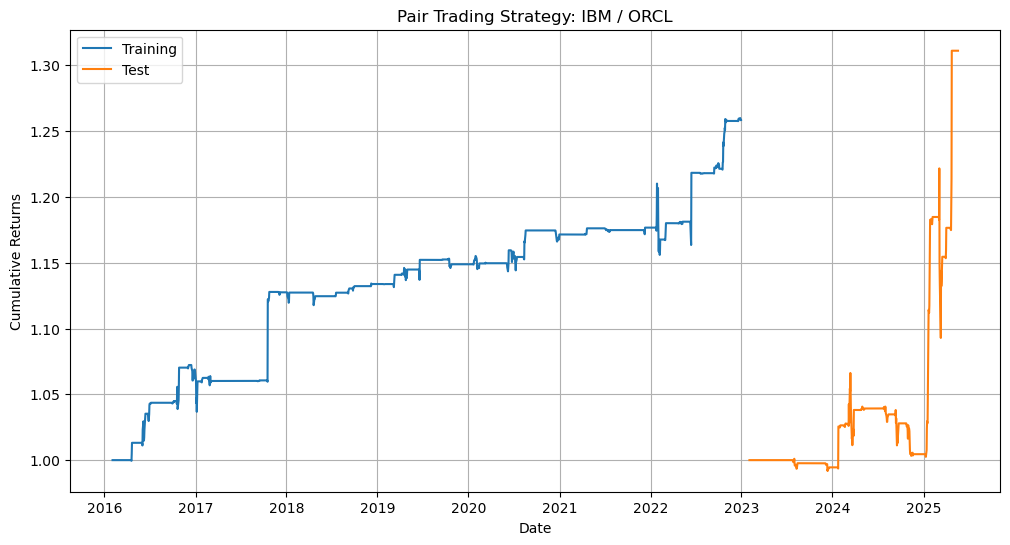

Cointegration test p-value: 0.0463
Pair is cointegrated. Proceeding.
Optimized thresholds: entry = 1.50, exit = 0.90
Training Performance:
  Sharpe Ratio: 0.61
  Max Drawdown: 17.14%
  Total Return: 95.64%
Test Performance:
  Sharpe Ratio: 0.78
  Max Drawdown: 8.28%
  Total Return: 30.70%


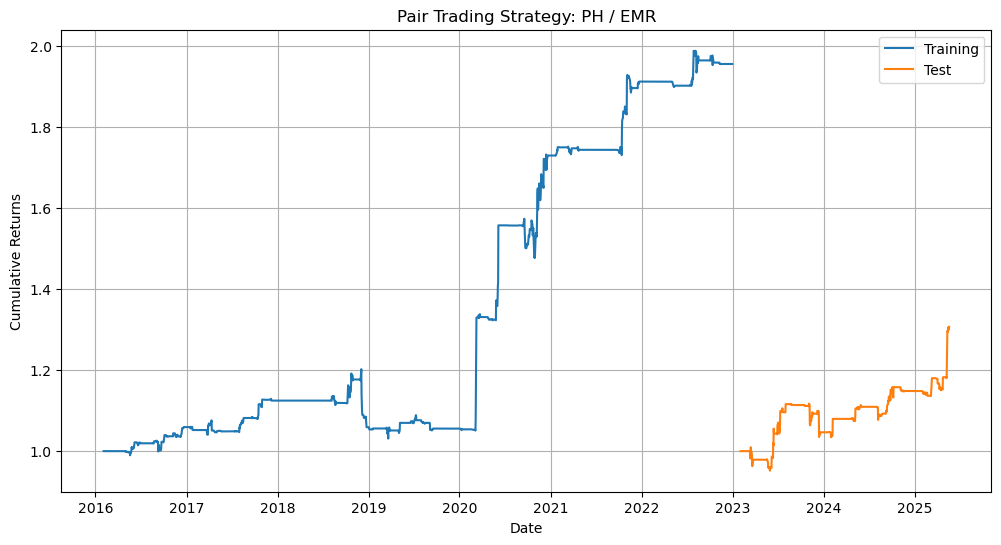

Cointegration test p-value: 0.0014
Pair is cointegrated. Proceeding.
Optimized thresholds: entry = 1.60, exit = 0.60
Training Performance:
  Sharpe Ratio: 0.28
  Max Drawdown: 10.77%
  Total Return: 37.09%
Test Performance:
  Sharpe Ratio: 0.31
  Max Drawdown: 5.84%
  Total Return: 10.19%


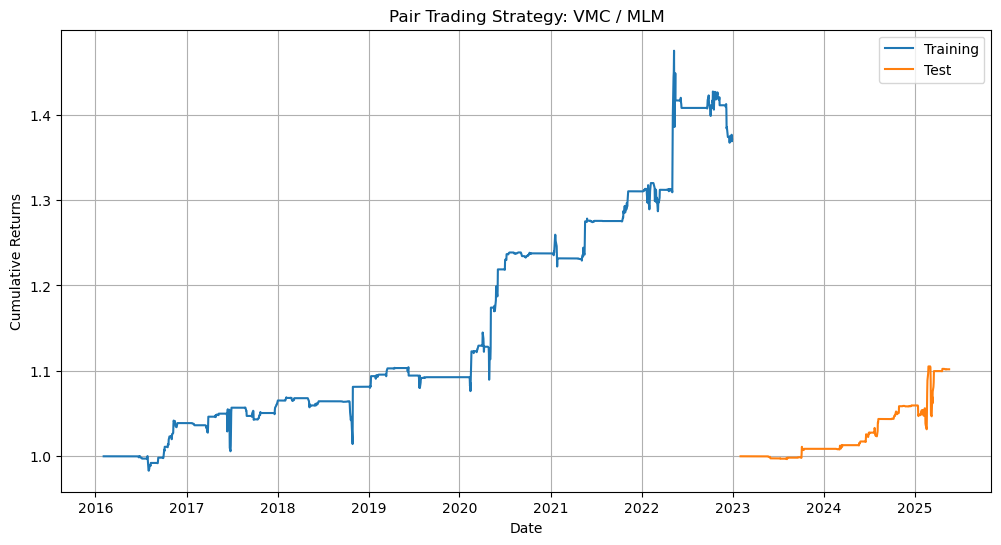

In [17]:
# Display performance plots for the top three cointegrated pairs

for i in range(3):
    # Instantiate the backtester for the i-th best-performing pair
    bt = PairTradingBacktester(
        tickers=pairs_and_ratios[i][0],
        start_date="2016-01-01",
        end_date=None,  # Uses latest available market data
        window=20,
        cost_per_trade=0.001,
        max_leverage=2.0,
        kelly_fraction=0.75
    )

    # Run the full backtesting process and display results
    bt.run(split_date="2023-01-01")
